# LArTPC Detector Data Clustering Analysis

This notebook processes raw LArIAT LArTPC detector data to identify and analyse particle tracks through clustering algorithms.

## What This Notebook Does

1. **Loads Raw Detector Data**: Reads ROOT files containing ADC (charge) measurements from 480 detector wires
2. **Separates Wire Planes**: Organizes data into:
   - **Induction Plane** (wires 0-239): First detection layer
   - **Collection Plane** (wires 240-479): Final detection layer  
3. **Creates Event Displays**: Generates 2D heatmaps showing particle tracks as they deposit energy
4. **Finds Particle Clusters**: Uses image processing to identify connected regions of detector hits
5. **Analyzes Track Properties**: Extracts start points, peak signals, and track characteristics

## Key Variables

- `collection.T` / `induction.T`: 2D matrices [time_ticks × wires] containing ADC values
- `col_props` / `ind_props`: List of detected particle track regions with properties
- `threshold`: Minimum ADC value to consider as a real signal (typically 30-120)

## Main Functions

- `find_largest_cluster()`: Finds the biggest particle track in the event
- `find_cluster_by_adc_ratio()`: Finds tracks with the highest signal variation (good for protons due to their Bragg Peak)
- `get_first_wire_max_adc()`: Locates track starting point coordinates
- `visualize_clusters_basic()`: Shows detector images with identified tracks highlighted


Mainly single-track proton events.

In [483]:
import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

In [485]:
ONE_TRACK_PROTONS = "/Users/user/data/research/proton-deuteron/csv/selectedprotons_onetrack_eventdisplay.csv"
RAW_FILES = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root"

# Some RAW data files
RAW0 = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008557_sr0002_20160529T072344_evtsel_1.root"
RAW1 = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008557_sr0004_20160529T072435_evtsel_1.root"
RAW2 = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008557_sr0007_20160529T072558_evtsel_1.root"
RAW3 = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008562_sr0146_20160530T075212_evtsel_1.root"

In [ ]:
# Open file
file = uproot.open(RAW0)
file.keys(), file.classnames()

(['ana;1', 'ana/raw;1'], {'ana;1': 'TDirectory', 'ana/raw;1': 'TTree'})

In [ ]:
# Open tree
tree = file["ana/raw"]
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
subrun               | int32_t                  | AsDtype('>i4')
event                | int32_t                  | AsDtype('>i4')
evttime              | double                   | AsDtype('>f8')
efield               | float                    | AsDtype('>f4')
lifetime             | float                    | AsDtype('>f4')
t0                   | int32_t                  | AsDtype('>i4')
raw_samples          | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), he...
raw_pedestal         | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_sigma            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_rawadc           | std::vector<int16_t>     | AsJagged(AsDtype('>i2'), he...
raw_channel          | std::vector<uint32_t>    | AsJagged(

In [535]:
# Looking at data in the file
data = tree.arrays(["raw_rawadc", "raw_channel"], library="ak")
data, len(data)

(<Array [{raw_rawadc: [...], ...}, {...}] type='2 * {raw_rawadc: var * int16...'>,
 2)

In [536]:
# Putting data into NumPy arrays

adc_data = ak.to_numpy(data[0]["raw_rawadc"])
channel_map = ak.to_numpy(data[0]["raw_channel"])
adc_data, channel_map, adc_data.shape, channel_map.shape

(array([2, 2, 2, ..., 2, 2, 3], shape=(1474560,), dtype=int16),
 array([ 47,  46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,
         34,  33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,
         21,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,
          8,   7,   6,   5,   4,   3,   2,   1,   0, 479, 478, 477, 476,
        475, 474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464, 399,
        398, 397, 396, 395, 394, 393, 392, 391, 390, 389, 388, 387, 386,
        385, 384, 383, 382, 381, 380, 379, 378, 377, 376, 375, 374, 373,
        372, 371, 370, 369, 368, 367, 366, 365, 364, 363, 362, 361, 360,
        359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 347,
        346, 345, 344, 343, 342, 341, 340, 339, 338, 337, 336, 335, 334,
        333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323, 322, 321,
        320, 319, 318, 317, 316, 315, 314, 313, 312, 311, 310, 309, 308,
        307, 306, 305, 304, 303, 302, 301, 300, 299, 298, 29

In [537]:
# Getting number of wires and number of ticks (the event display coordinates)

num_channels_in_event = len(channel_map) # 480 - 240 in collection, 240 in induction - number of wires
num_ticks = len(adc_data) // num_channels_in_event # 480 wires, record a sample 3072 times. 
num_channels_in_event, num_ticks

(480, 3072)

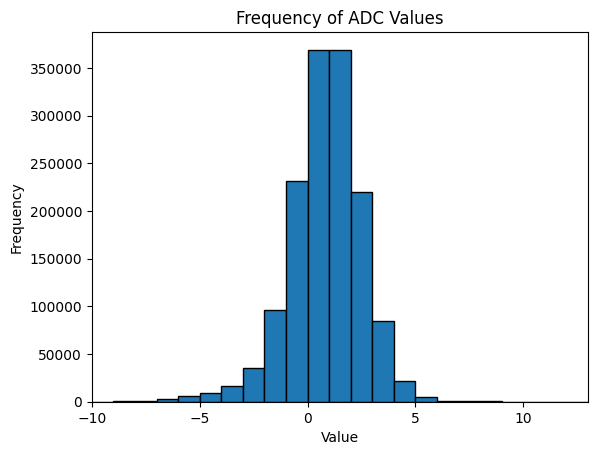

In [538]:
# Plotting histogram to understand what background ADC values look like.

plt.hist(adc_data, bins='auto', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of ADC Values')
plt.xlim(-10, 13)
# plt.ylim(0, 100)
plt.show()

# Most are obviously around 0 - helps put a threshold.

In [539]:
# Turning flat ADC array into 2D array. Each 3072 values are one wire, over 3072 time ticks. Wire are not ordered, but their index is given in channel_map.

adc_data2d = adc_data.reshape((num_channels_in_event, num_ticks)) # wire numbers not ordered, every 3072 is one channel
adc_data2d

array([[ 2,  2,  2, ...,  2,  2,  2],
       [ 0,  0,  0, ..., -2, -3, -3],
       [ 1,  2,  1, ...,  1,  1,  1],
       ...,
       [ 2,  2,  2, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  3]], shape=(480, 3072), dtype=int16)

In [540]:
# Initialising arrays for the two wire planes

collection = np.zeros((240, num_ticks))
induction = np.zeros((240, num_ticks))

In [541]:
# Organising the wires properly and data input into collection and induction. 

for i, channel_num in enumerate(channel_map):
    if 0 <= channel_num < 240:
        wire_index = channel_num
        induction[wire_index, :] = adc_data2d[i, :] # each row is a channel/wire, going 0 -> 239 (ordered) we have 240 rows, each with 3072 columns (time)
    if 240 <= channel_num < 480:
        wire_index = channel_num - 240
        collection[wire_index, :] = adc_data2d[i, :]  # each row is a channel/wire, going 240 -> 479 (orded)

In [542]:
# Final arrays 

induction, collection

(array([[ 0.,  0.,  0., ..., -1., -1., -1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 2.,  3.,  3., ...,  0.,  0.,  0.],
        [ 1.,  1.,  1., ...,  2.,  1.,  1.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.]], shape=(240, 3072)),
 array([[ 0.,  0.,  1., ...,  0.,  1.,  1.],
        [ 3.,  3.,  3., ...,  2.,  2.,  2.],
        [ 2.,  2.,  2., ...,  0.,  0., -1.],
        ...,
        [ 1.,  1.,  1., ..., -1.,  0.,  0.],
        [ 3.,  3.,  3., ..., -1., -1., -2.],
        [ 1.,  1.,  1., ...,  0.,  0.,  0.]], shape=(240, 3072)))

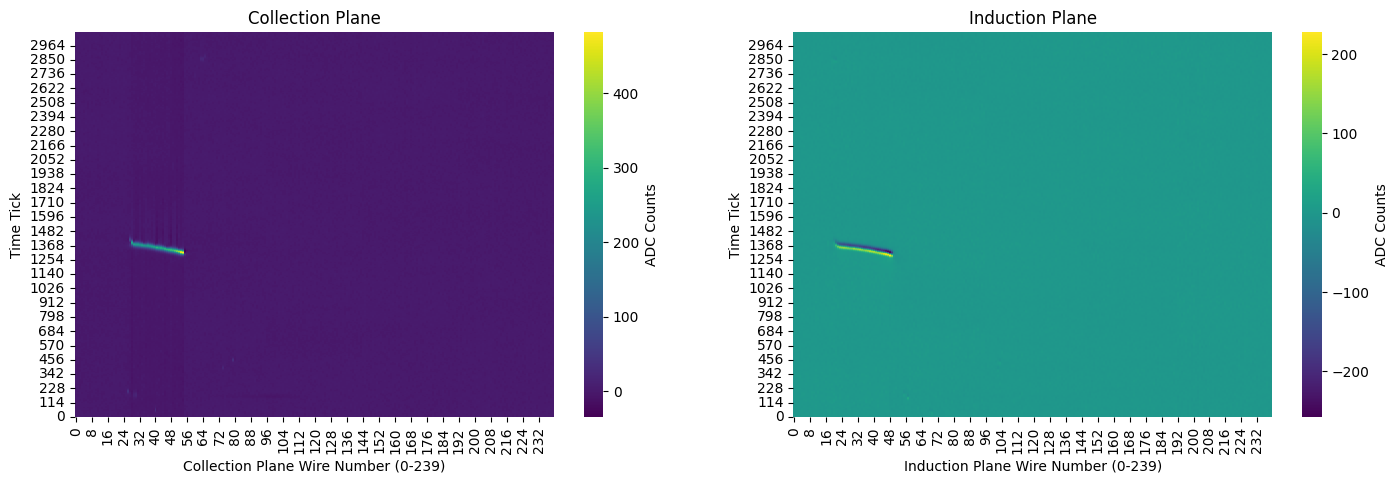

In [543]:
# Event displays

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))


sns.heatmap(collection.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
ax1.set_xlabel("Collection Plane Wire Number (0-239)")
ax1.set_ylabel("Time Tick")
ax1.set_title("Collection Plane")
ax1.invert_yaxis()

sns.heatmap(induction.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
ax2.set_xlabel("Induction Plane Wire Number (0-239)")
ax2.set_ylabel("Time Tick")
ax2.set_title("Induction Plane")
ax2.invert_yaxis()

# Finding clusters through a simple threshold.

## HOW THIS WORKS:
Create a binary mask using a simple threshold for the ADC value (e.g. 50). So you get a 240 x 3072 matrix, where every value below 50 gets turned into a 0, and above 50 gets turned into a 1. 

Then we input this matrix to find connected regions. Two pixels (elements in the matrix) are connected if they have the same value (here 1's together will be connected, 0's are disregarded). skimage's label then returns a matrix with 0's being background, and each cluster having values 1, 2, 3, 4 (therefore, pixels in cluster 1, will all have value 1, in cluster two, will have value 2, and so on.)  

This labelled matrix matrix is then input into 'regionprops' that gives the properties of the region, such as the bounding box, area, etc. and also takes the original ADCs into consideration to calculate min, max intensity, etc. 

In [544]:
# Finding clusters through a simple threshold.

from skimage.measure import label, regionprops

def find_connected_regions(matrix, threshold=10):
    """Find connected regions of signal above threshold"""
    # Create binary mask (matrix 240 x 3072) of significant signals.
    # (True (1) for above threshold, False (0) for below threshold.)
    binary_mask = matrix > threshold
    
    # Label connected pixels
    labeled_regions, num_regions = label(binary_mask, return_num=True)
    
    print(f"Found {num_regions} connected regions")
    
    # Properties of each region
    regions = regionprops(labeled_regions, intensity_image=matrix) # arg "intensity_image" re-introduces the ADC values, now that clusters are identified. 
    
    for i, region in enumerate(regions):
        print(f"Region {i+1}:")
        print(f"  Area: {region.area} pixels")
        print(f"  Max intensity: {region.intensity_max:.1f}")
        
        # Total intensity using the original matrix and region coordinates
        total_intensity = matrix[region.coords[:, 0], region.coords[:, 1]].sum()
        print(f"  Total intensity: {total_intensity:.1f}")
    
    return labeled_regions, regions

# Applying to both planes
print("Collection Plane Clustering:")
col_regions, col_props = find_connected_regions(collection.T, threshold=50)

print("\nInduction Plane Clustering:")
ind_regions, ind_props = find_connected_regions(induction.T, threshold=50)

Collection Plane Clustering:
Found 1 connected regions
Region 1:
  Area: 1400.0 pixels
  Max intensity: 482.0
  Total intensity: 247760.0

Induction Plane Clustering:
Found 1 connected regions
Region 1:
  Area: 704.0 pixels
  Max intensity: 228.0
  Total intensity: 81643.0


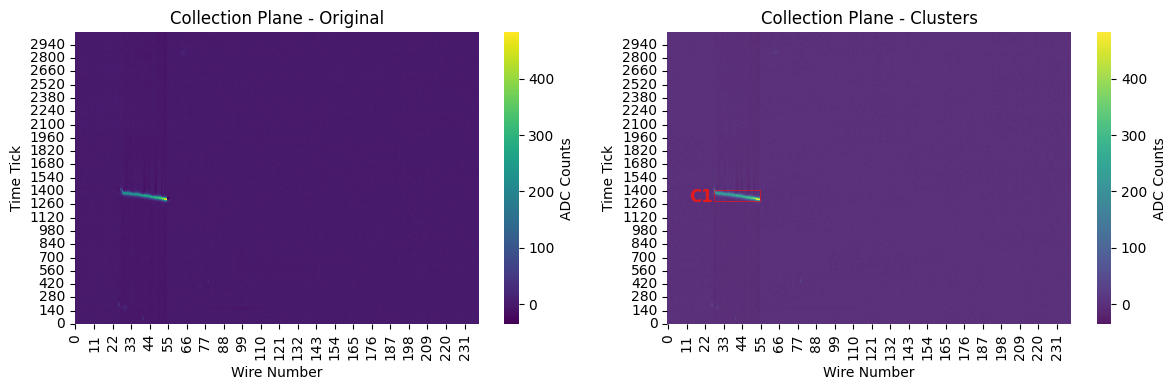

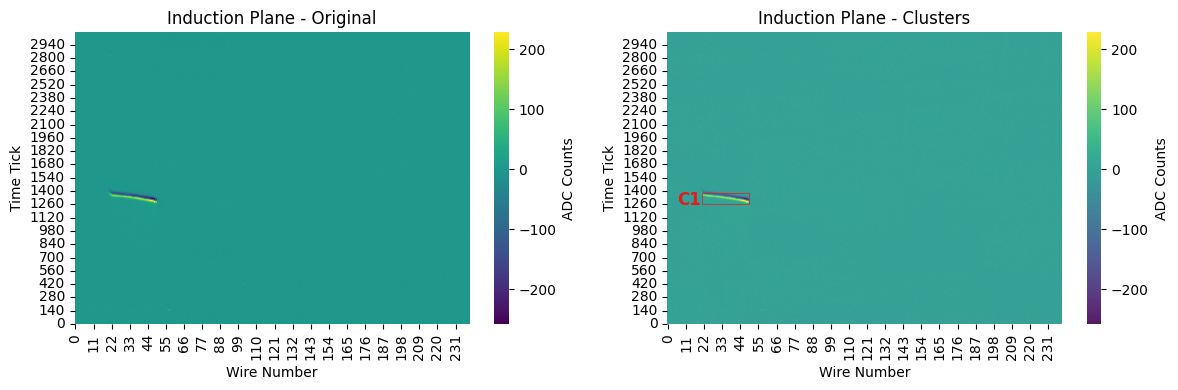

In [591]:
# Visulaising regions

def visualize_clusters_basic(matrix, labeled_regions, regions, plane_name):
    """Basic visualization of clusters overlaid on detector image"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Original heatmap
    sns.heatmap(matrix, cmap="viridis", ax=ax1, cbar_kws={'label': 'ADC Counts'})
    ax1.set_title(f"{plane_name} - Original")
    ax1.set_xlabel("Wire Number")
    ax1.set_ylabel("Time Tick")
    ax1.invert_yaxis()
    
    # Clusters overlay
    sns.heatmap(matrix, cmap="viridis", ax=ax2, alpha=0.9, cbar_kws={'label': 'ADC Counts'})
    
    # Cluster boundaries
    import matplotlib.patches as patches
    colors = plt.cm.Set1(np.linspace(0, 1, len(regions)))
    
    for i, (region, color) in enumerate(zip(regions, colors)):
        # Bounding box
        minr, minc, maxr, maxc = region.bbox
        
        # Rectangle around cluster
        rect = patches.Rectangle((minc, minr), maxc-minc, maxr-minr,
                               linewidth=0.5, edgecolor=color, facecolor='none')
        ax2.add_patch(rect)
        
        # Cluster label
        ax2.text(minc-15, minr-10, f'C{i+1}', color=color, fontweight='bold', fontsize=12)
    
    ax2.set_title(f"{plane_name} - Clusters")
    ax2.set_xlabel("Wire Number")
    ax2.set_ylabel("Time Tick")
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Both planes
if col_regions is not None and len(col_props) > 0:
    visualize_clusters_basic(collection.T, col_regions, col_props, "Collection Plane")

if ind_regions is not None and len(ind_props) > 0:
    visualize_clusters_basic(induction.T, ind_regions, ind_props, "Induction Plane")

Want only one cluster - the one with the proton, others are irrelevant. Maybe good to select a threshold for region area (cluster size)? This will remove small products from inelastic scaterring, stuff happening due to neutrons. 

However, if muons are involved, this might prioritise them over shorter protons. 

In [546]:
def find_largest_cluster(matrix, threshold=10):
    """Find only the largest connected region above threshold"""
    binary_mask = matrix > threshold
    labeled_regions, num_regions = label(binary_mask, return_num=True)
    
    print(f"Found {num_regions} connected regions")
    
    if num_regions == 0:
        return None, None

    regions = regionprops(labeled_regions, intensity_image=matrix)
    
    # The largest region by area
    largest_region = max(regions, key=lambda r: r.area)
    largest_idx = regions.index(largest_region)
    
    print(f"Largest Region:")
    print(f"  Area: {largest_region.area} pixels")
    print(f"  Centroid: ({largest_region.centroid[0]:.1f}, {largest_region.centroid[1]:.1f})")
    print(f"  Max intensity: {largest_region.intensity_max:.1f}")

    total_intensity = matrix[largest_region.coords[:, 0], largest_region.coords[:, 1]].sum()
    print(f"  Total intensity: {total_intensity:.1f}")
    
    # New labeled image with only the largest region
    single_cluster_mask = labeled_regions == (largest_idx + 1)
    
    return single_cluster_mask.astype(int), [largest_region]

# Single cluster only
print("Collection Plane - Largest Cluster:")
col_regions, col_props = find_largest_cluster(collection.T, threshold=50)

print("\nInduction Plane - Largest Cluster:")
ind_regions, ind_props = find_largest_cluster(induction.T, threshold=50)

Collection Plane - Largest Cluster:
Found 1 connected regions
Largest Region:
  Area: 1400.0 pixels
  Centroid: (1350.4, 41.1)
  Max intensity: 482.0
  Total intensity: 247760.0

Induction Plane - Largest Cluster:
Found 1 connected regions
Largest Region:
  Area: 704.0 pixels
  Centroid: (1324.6, 35.6)
  Max intensity: 228.0
  Total intensity: 81643.0


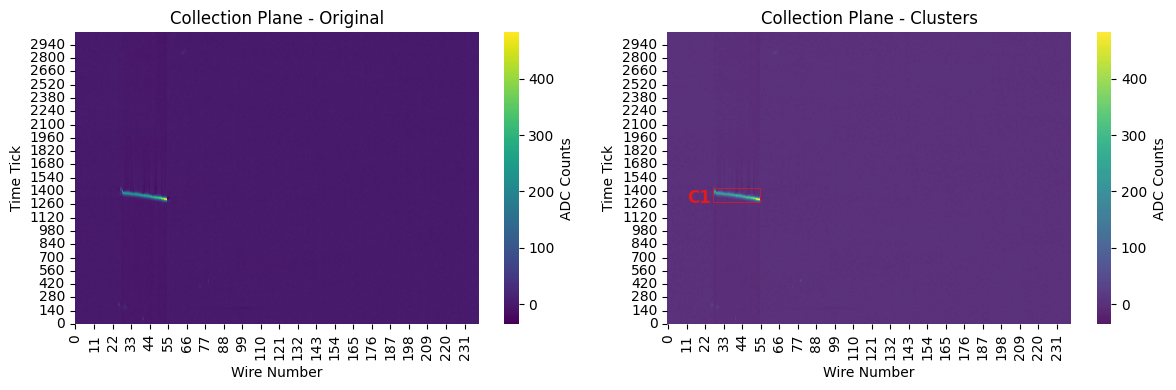

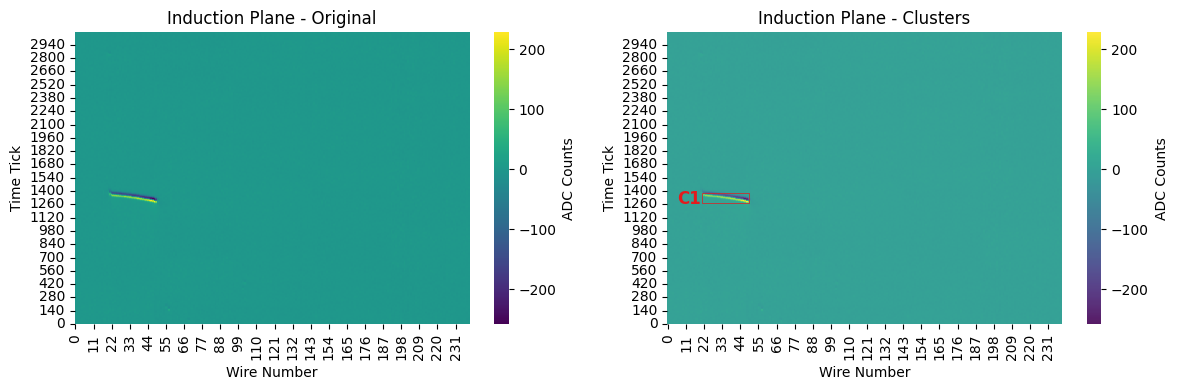

In [547]:
# Visualising

if col_regions is not None and len(col_props) > 0:
    visualize_clusters_basic(collection.T, col_regions, col_props, "Collection Plane")

if ind_regions is not None and len(ind_props) > 0:
    visualize_clusters_basic(induction.T, ind_regions, ind_props, "Induction Plane")


Or by ratio of min-max ADC. This would take advantage of Bragg peak characteristic of proton tracks. Might work better with events with muons. 

In [548]:
def find_cluster_by_adc_ratio(matrix, threshold=10):
    """Find cluster with the largest max/min ADC ratio"""

    binary_mask = matrix > threshold
    
    labeled_regions, num_regions = label(binary_mask, return_num=True)
    
    print(f"Found {num_regions} connected regions")
    
    if num_regions == 0:
        return None, None
    
    regions = regionprops(labeled_regions, intensity_image=matrix)
    
    # Calculate ADC ratio for each region
    adc_ratios = []
    for region in regions:
        region_values = matrix[region.coords[:, 0], region.coords[:, 1]] # getting ADC values of pixels in region.
        min_adc = region_values.min() 
        max_adc = region_values.max()
        
        # Avoid division by zero
        if min_adc > 0:
            adc_ratio = max_adc / min_adc
        else:
            adc_ratio = max_adc / (min_adc + 1e-6)  # Add small epsilon
        
        adc_ratios.append(adc_ratio)
    
    # Region with largest ADC ratio
    max_ratio_idx = np.argmax(adc_ratios)
    selected_region = regions[max_ratio_idx]
    
    # ADC statistics for selected region
    region_values = matrix[selected_region.coords[:, 0], selected_region.coords[:, 1]]
    min_adc = region_values.min()
    max_adc = region_values.max()
    adc_ratio = adc_ratios[max_ratio_idx]
    
    print(f"Region with largest ADC ratio:")
    print(f"  Min ADC: {min_adc:.1f}")
    print(f"  Max ADC: {max_adc:.1f}")
    print(f"  ADC Ratio (max/min): {adc_ratio:.2f}")
    print(f"  Area: {selected_region.area} pixels")
    print(f"  Centroid: ({selected_region.centroid[0]:.1f}, {selected_region.centroid[1]:.1f})")
    
    # Labeled image with only the selected region
    single_cluster_mask = labeled_regions == (max_ratio_idx + 1)
    
    return single_cluster_mask.astype(int), [selected_region]

print("Collection Plane - Largest ADC Ratio:")
col_regions, col_props = find_cluster_by_adc_ratio(collection.T, threshold=120)

print("\nInduction Plane - Largest ADC Ratio:")
ind_regions, ind_props = find_cluster_by_adc_ratio(induction.T, threshold=30)

Collection Plane - Largest ADC Ratio:
Found 1 connected regions
Region with largest ADC ratio:
  Min ADC: 121.0
  Max ADC: 482.0
  ADC Ratio (max/min): 3.98
  Area: 916.0 pixels
  Centroid: (1348.9, 41.8)

Induction Plane - Largest ADC Ratio:
Found 2 connected regions
Region with largest ADC ratio:
  Min ADC: 31.0
  Max ADC: 228.0
  ADC Ratio (max/min): 7.35
  Area: 843.0 pixels
  Centroid: (1323.7, 35.4)


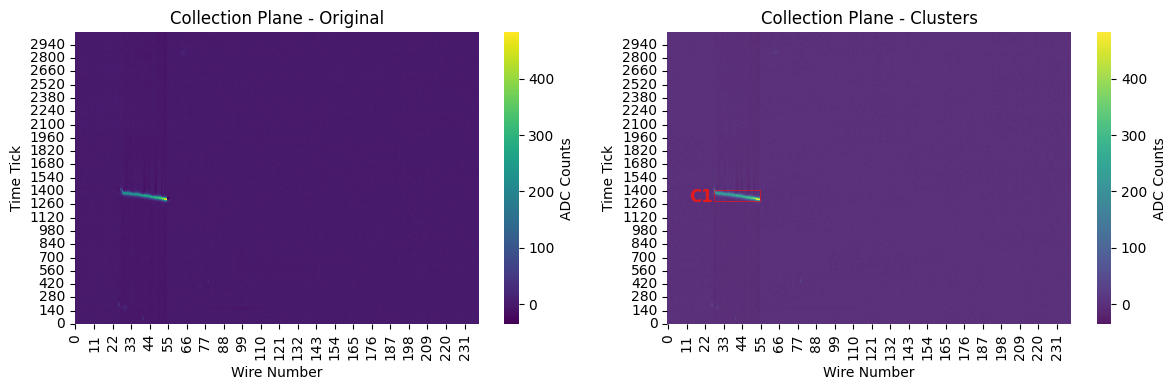

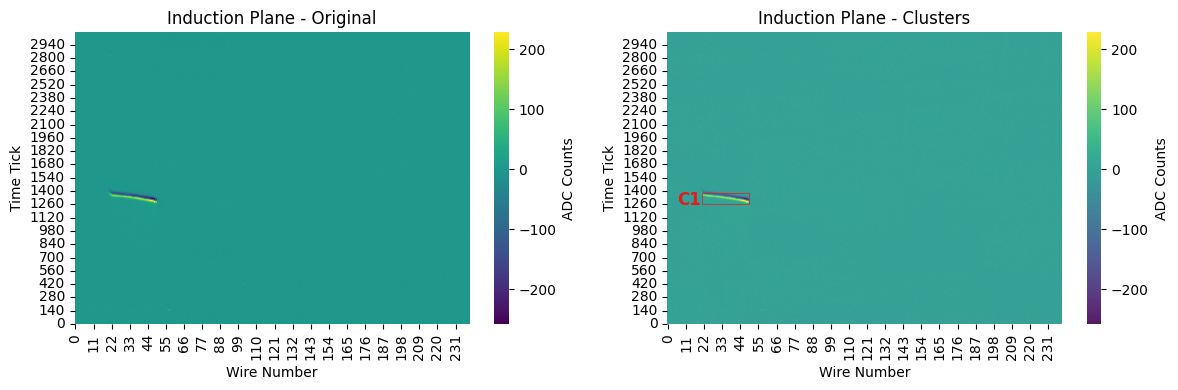

In [549]:
# Visualising

if col_regions is not None and len(col_props) > 0:
    visualize_clusters_basic(collection.T, col_regions, col_props, "Collection Plane")

if ind_regions is not None and len(ind_props) > 0:
    visualize_clusters_basic(induction.T, ind_regions, ind_props, "Induction Plane")


Combine the two? How to improve for muons - better thresholding, checking for sudden dips if muon + proton event? 

How to find first point coordinate? Need this for deuteron search from the deuteron candidates.

Solution 1: Taking first wire, then find the time tick with the highest ADC.

In [550]:
def get_first_wire_max_adc(region, matrix):
    """Find first wire in region, then get time tick with highest ADC on that wire"""
    
    # Bounding box to find first (minimum) wire
    min_time, min_wire, max_time, max_wire = region.bbox
    
    print(f"First wire in region: {min_wire}")
    
    # All pixels in the cluster on the first wire
    coords = region.coords
    first_wire_pixels = coords[coords[:, 1] == min_wire]  # coords[:, 1] is wire column
    
    if len(first_wire_pixels) == 0:
        print(f"No pixels found on first wire {min_wire} (this shouldn't happen)")
        return None, None, None
    
    # ADC values for all pixels on the first wire
    first_wire_times = first_wire_pixels[:, 0]  # coords[:, 0] is time column
    first_wire_adcs = matrix[first_wire_times, min_wire]
    
    # The time tick with maximum ADC on this wire
    max_adc_idx = np.argmax(first_wire_adcs)
    max_adc_time = first_wire_times[max_adc_idx]
    max_adc_value = first_wire_adcs[max_adc_idx]
    
    print(f"On first wire {min_wire}:")
    print(f"  Max ADC value: {max_adc_value:.1f}")
    print(f"  Coordinate: (wire={min_wire}, time={max_adc_time})")
    
    return min_wire, max_adc_time, max_adc_value

# Apply to existing clusters
if col_props and len(col_props) > 0:
    print("Collection Plane - First wire max ADC:")
    col_wire, col_time, col_adc = get_first_wire_max_adc(col_props[0], collection.T)
    
if ind_props and len(ind_props) > 0:
    print("\nInduction Plane - First wire max ADC:")
    ind_wire, ind_time, ind_adc = get_first_wire_max_adc(ind_props[0], induction.T)

Collection Plane - First wire max ADC:
First wire in region: 28
On first wire 28:
  Max ADC value: 264.0
  Coordinate: (wire=28, time=1391)

Induction Plane - First wire max ADC:
First wire in region: 21
On first wire 21:
  Max ADC value: 73.0
  Coordinate: (wire=21, time=1369)


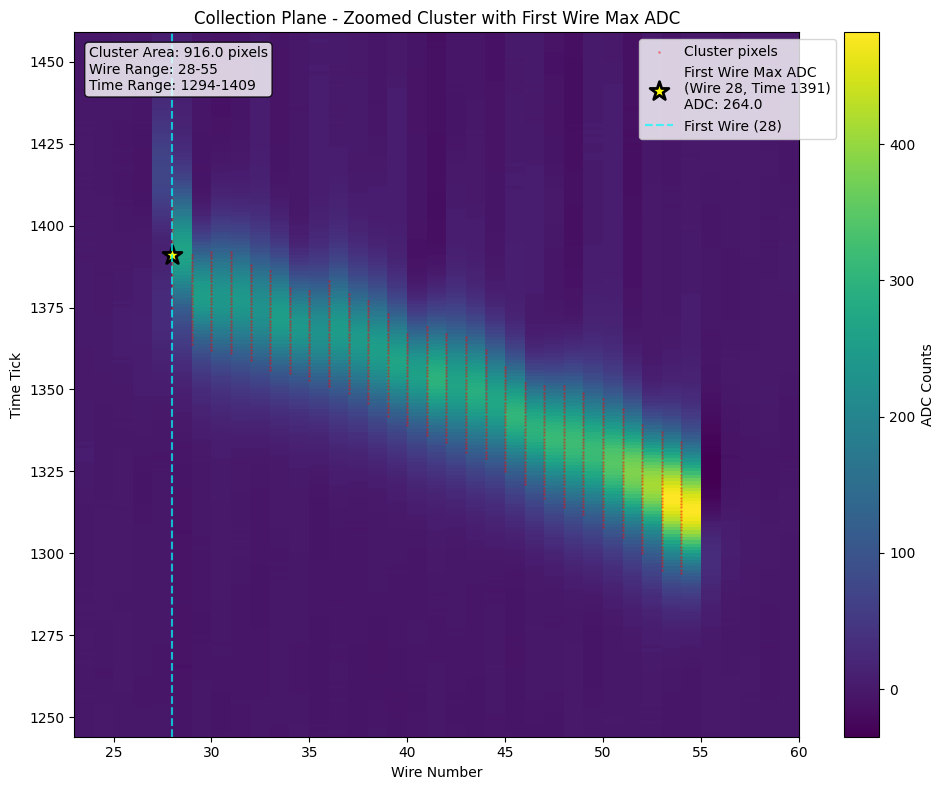

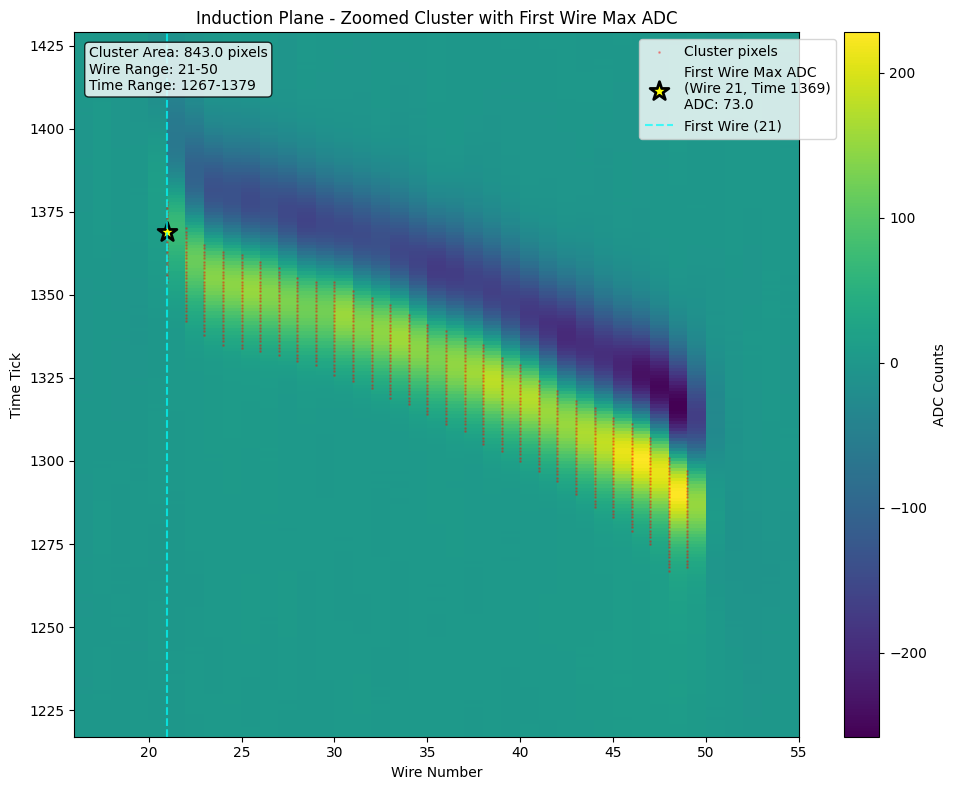

In [551]:
def plot_first_wire_coordinate(region, matrix, plane_name, first_wire_coord=None):
    """Plot event display zoomed to cluster with first wire max ADC coordinate marked"""
    
    # Cluster bounding box for zooming
    min_time, min_wire, max_time, max_wire = region.bbox
    
    # Padding around the cluster
    padding_time = max(50, int((max_time - min_time) * 0.1))
    padding_wire = max(5, int((max_wire - min_wire) * 0.1))
    
    zoom_min_time = max(0, min_time - padding_time)
    zoom_max_time = min(matrix.shape[0], max_time + padding_time)
    zoom_min_wire = max(0, min_wire - padding_wire)
    zoom_max_wire = min(matrix.shape[1], max_wire + padding_wire)
    
    # Coomed region
    zoomed_matrix = matrix[zoom_min_time:zoom_max_time, zoom_min_wire:zoom_max_wire]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    im = ax.imshow(zoomed_matrix, cmap='viridis', aspect='auto', 
                   extent=[zoom_min_wire, zoom_max_wire, zoom_max_time, zoom_min_time])
    
    plt.colorbar(im, ax=ax, label='ADC Counts')
    
    # Marking the cluster boundary
    cluster_coords = region.coords
    cluster_in_zoom = cluster_coords[
        (cluster_coords[:, 0] >= zoom_min_time) & (cluster_coords[:, 0] < zoom_max_time) &
        (cluster_coords[:, 1] >= zoom_min_wire) & (cluster_coords[:, 1] < zoom_max_wire)
    ]
    
    if len(cluster_in_zoom) > 0:
        ax.scatter(cluster_in_zoom[:, 1], cluster_in_zoom[:, 0], 
                  c='red', s=1, alpha=0.3, label='Cluster pixels')
    
    # Mark the first wire max ADC coordinate
    if first_wire_coord is not None:
        wire, time, adc = first_wire_coord
        if (zoom_min_wire <= wire < zoom_max_wire and 
            zoom_min_time <= time < zoom_max_time):
            ax.scatter(wire, time, c='yellow', s=200, marker='*', 
                      edgecolors='black', linewidth=2, 
                      label=f'First Wire Max ADC\n(Wire {wire}, Time {time})\nADC: {adc:.1f}')
    
    # Mark first wire line
    if zoom_min_wire <= min_wire < zoom_max_wire:
        ax.axvline(x=min_wire, color='cyan', linestyle='--', alpha=0.7, 
                   label=f'First Wire ({min_wire})')
    
    ax.set_xlabel('Wire Number')
    ax.set_ylabel('Time Tick')
    ax.set_title(f'{plane_name} - Zoomed Cluster with First Wire Max ADC')
    ax.legend(bbox_to_anchor=(0.77, 1), loc='upper left')
    
    # Add text box with cluster info
    info_text = (f'Cluster Area: {region.area} pixels\n'
                f'Wire Range: {min_wire}-{max_wire}\n'
                f'Time Range: {min_time}-{max_time}')
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Plot for both planes with first wire coordinates
if col_props and len(col_props) > 0 and 'col_wire' in locals():
    first_wire_coord = (col_wire, col_time, col_adc)
    plot_first_wire_coordinate(col_props[0], collection.T, "Collection Plane", first_wire_coord)

if ind_props and len(ind_props) > 0 and 'ind_wire' in locals():
    first_wire_coord = (ind_wire, ind_time, ind_adc)
    plot_first_wire_coordinate(ind_props[0], induction.T, "Induction Plane", first_wire_coord)

# All 1-track proton event cadidates.

Need to go through all the 7636 proton cadidates, do the data processing, apply simple clustering, find and record vertex.

Then, maybe, apply a 2D Gaussian fit over these, and use this to search for deuterons. 

1. Matching events from ONE_TRACK_PROTONS and RAW_FILES (proton candidates RAW files)
2. The whole data pipeline
3. Vertex coordinates in wire vs. time tick.

In [553]:
onetrackprotons = pd.read_csv(ONE_TRACK_PROTONS)
onetrackprotons

,run,subrun,event
0,8557,10,734
1,8557,106,5048
2,8557,109,5156
3,8557,109,5191
4,8557,110,5209
...,...,...,...
7631,9788,69,4963
7632,9788,71,5150
7633,9788,8,595
7634,9788,82,6063


In [560]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from search_worker import process_single_file
from tqdm import tqdm
from pathlib import Path

In [561]:
def search_files(df, root_files_dir, max_workers=None):
    """
    Search all ROOT files in parallel for events that match events provided in df. Uses script "search_worker.py"
    """

    target_events = set(zip(
        df['run'].astype(int),
        df['subrun'].astype(int),
        df['event'].astype(int)
    ))

    root_files_dir = Path(RAW_FILES)
    root_files = list(root_files_dir.glob("*.root"))

    print(f"Found {len(root_files)} ROOT files. Starting parallel search...")

    matched = []

    with ProcessPoolExecutor(max_workers=max_workers) as executor:

        futures = [executor.submit(process_single_file, path, target_events) for path in root_files]
        
        for future in tqdm(as_completed(futures), total=len(root_files), desc="Searching Files"):
            result = future.result()
            if result:
                matched.extend(result)
    
    print(f"\nSearch complete! Found {len(matched)} matching events.")

    matched_events = sorted(matched, key=lambda x: (x['run'], x['subrun'], x['event']))
    return matched_events

In [562]:
matched = search_files(onetrackprotons, RAW_FILES)

Found 12531 ROOT files. Starting parallel search...


Searching Files: 100%|██████████| 12531/12531 [00:14<00:00, 871.44it/s] 


Search complete! Found 7636 matching events.


In [568]:
matched[0]

{'run': np.int32(8557),
 'subrun': np.int32(7),
 'event': np.int32(596),
 'file_path': '/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root/extracted_lariat_digit_r008557_sr0007_20160529T072558_evtsel_1.root',
 'filename': 'extracted_lariat_digit_r008557_sr0007_20160529T072558_evtsel_1.root',
 'event_index_in_file': 0}

In [599]:
def clustering(filepath, event_index, run, subrun, event):

    file = uproot.open(filepath) # open file
    tree = file["ana/raw"] # open tree
    
    data = tree.arrays(["raw_rawadc", "raw_channel"], library="ak")
    adc_data = ak.to_numpy(data[event_index]["raw_rawadc"])
    channel_map = ak.to_numpy(data[event_index]["raw_channel"])

    num_channels_in_event = len(channel_map)
    num_ticks = len(adc_data) // num_channels_in_event

    adc_data2d = adc_data.reshape((num_channels_in_event, num_ticks))

    collection = np.zeros((240, num_ticks))
    induction = np.zeros((240, num_ticks))

    for i, channel_num in enumerate(channel_map):
        if 0 <= channel_num < 240:
            wire_index = channel_num
            induction[wire_index, :] = adc_data2d[i, :] 
        if 240 <= channel_num < 480:
            wire_index = channel_num - 240
            collection[wire_index, :] = adc_data2d[i, :] 

    col_regions, col_props = find_cluster_by_adc_ratio(collection.T, threshold=120)
    ind_regions, ind_props = find_cluster_by_adc_ratio(induction.T, threshold=30)

    # visualise
    # if col_regions is not None and len(col_props) > 0:
    #     visualize_clusters_basic(collection.T, col_regions, col_props, "Collection Plane")

    # if ind_regions is not None and len(ind_props) > 0:
    #     visualize_clusters_basic(induction.T, ind_regions, ind_props, "Induction Plane")

    if col_props and len(col_props) > 0:
        col_wire, col_time, col_adc = get_first_wire_max_adc(col_props[0], collection.T)
    
    if ind_props and len(ind_props) > 0:
        ind_wire, ind_time, ind_adc = get_first_wire_max_adc(ind_props[0], induction.T)

    return run, subrun, event, col_wire, col_time, ind_wire, ind_time

In [600]:
indices_data = pd.DataFrame(columns=["run", "subrun", "event", "col_wire", "col_time", "ind_wire", "ind_time"])

In [601]:
indices_data

,run,subrun,event,col_wire,col_time,ind_wire,ind_time


In [ ]:
for i in matched:
    run = i["run"]
    subrun = i["subrun"]
    event = i["event"]
    file_path = i["file_path"]
    event_index_in_file = i["event_index_in_file"]

    result = clustering(file_path, event_index_in_file, run, subrun, event)
    indices_data.loc[len(indices_data)] = result

In [579]:
indices_data

,run,subrun,event,col_wire,col_time,ind_wire,ind_time
0,8557,7,596,32,945,15,920
1,8557,9,700,28,1213,21,1198
2,8557,10,734,26,1227,23,1200
3,8557,16,995,32,1261,16,1220
4,8557,16,1015,37,1527,13,1507
...,...,...,...,...,...,...,...
7631,9788,297,26027,49,945,13,949
7632,9788,299,26208,48,1188,25,1206
7633,9788,305,26707,34,962,14,944
7634,9788,308,26943,39,976,20,978


In [ ]:
# indices.to_csv('indicies_v0.csv', index=False)

In [603]:
indices = pd.read_csv('indicies_v0.csv')

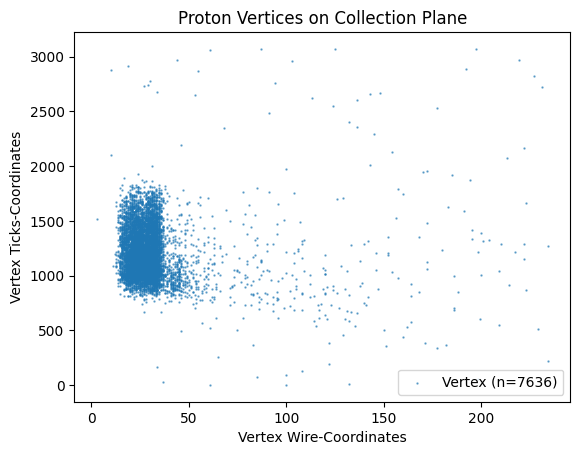

In [604]:
col_wire = np.array(indices['col_wire'].values)
col_time = np.array(indices['col_time'].values)

plt.figure()
plt.scatter(col_wire, col_time, s=0.5, alpha=0.6, label=f'Vertex (n={len(col_wire)})')
plt.xlabel('Vertex Wire-Coordinates')
plt.ylabel('Vertex Ticks-Coordinates')
plt.title('Proton Vertices on Collection Plane')
plt.legend()
plt.show()

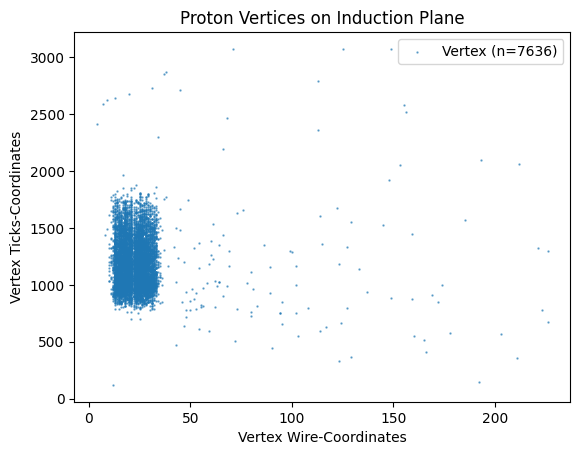

In [605]:
ind_wire = np.array(indices['ind_wire'].values)
ind_time = np.array(indices['ind_time'].values)

plt.figure()
plt.scatter(ind_wire, ind_time, s=0.5, alpha=0.6, label=f'Vertex (n={len(col_wire)})')
plt.xlabel('Vertex Wire-Coordinates')
plt.ylabel('Vertex Ticks-Coordinates')
plt.title('Proton Vertices on Induction Plane')
plt.legend()
plt.show()

In [ ]:
# matching time
# threshold improvement
# clustering on clusters, for complex events.